In [3]:
import numpy as np

print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.661563238158
- learns first dependency:   0.519166699707
- learns both dependencies:  0.454454367449


In [4]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [5]:
# Global config variables
num_steps = 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [6]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [7]:
tf.reset_default_graph()
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)



In [8]:
""""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell.
"""
with tf.variable_scope('rnn_cell'):
    W_h = tf.get_variable('W_h', [num_classes + state_size, state_size]) # Concatenating W_hh and W_xh for efficiency
    b_h = tf.get_variable('b_h', [state_size], initializer=tf.constant_initializer(0.0))


def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W_h = tf.get_variable('W_h', [num_classes + state_size, state_size])
        b_h = tf.get_variable('b_h', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], axis=1), W_h) + b_h)

In [9]:
"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [10]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W_y = tf.get_variable('W_y', [state_size, num_classes])
    b_y = tf.get_variable('b_y', [num_classes], initializer=tf.constant_initializer(0.0))
    
logits = [tf.matmul(rnn_output, W_y) + b_y for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = []
for logit, label in zip(logits, y_as_list):
    losses.append(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit))

total_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [11]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        epoch_training_losses = np.zeros(num_epochs)
        
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            training_losses = []
            
            print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              optimizer],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                
                if step % 100 == 0 and step > 0:
                    print("Average loss at step", step,
                              ":", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
                    
            
            epoch_training_losses[idx] = np.mean(np.array(training_losses))
            print("Epoch training loss :", epoch_training_losses[idx])

    return epoch_training_losses


EPOCH 0
Average loss at step 100 : 0.564522241354
Average loss at step 200 : 0.522128885388
Average loss at step 300 : 0.521052979827
Average loss at step 400 : 0.519054949284
Average loss at step 500 : 0.524261210263
Average loss at step 600 : 0.51894816488
Average loss at step 700 : 0.518813562989
Average loss at step 800 : 0.519155274332
Average loss at step 900 : 0.519530082047
Epoch training loss : 0.52527415004

EPOCH 1
Average loss at step 100 : 0.525667688847
Average loss at step 200 : 0.520542412698
Average loss at step 300 : 0.517638013363
Average loss at step 400 : 0.518034579158
Average loss at step 500 : 0.5166153422
Average loss at step 600 : 0.521813015342
Average loss at step 700 : 0.519313836694
Average loss at step 800 : 0.518611475527
Average loss at step 900 : 0.519285955131
Epoch training loss : 0.519724702107

EPOCH 2
Average loss at step 100 : 0.527044809163
Average loss at step 200 : 0.519960045516
Average loss at step 300 : 0.518204390407
Average loss at step 

Average loss at step 500 : 0.510507645905
Average loss at step 600 : 0.510154648423
Average loss at step 700 : 0.508282347023
Average loss at step 800 : 0.51194645524
Average loss at step 900 : 0.51036239624
Epoch training loss : 0.510714095036

EPOCH 20
Average loss at step 100 : 0.517221550941
Average loss at step 200 : 0.512515731156
Average loss at step 300 : 0.513666501939
Average loss at step 400 : 0.511531083584
Average loss at step 500 : 0.510558236837
Average loss at step 600 : 0.51179567039
Average loss at step 700 : 0.510507135689
Average loss at step 800 : 0.508725916445
Average loss at step 900 : 0.511704852879
Epoch training loss : 0.512025186651

EPOCH 21
Average loss at step 100 : 0.516947077513
Average loss at step 200 : 0.511546642482
Average loss at step 300 : 0.510426007807
Average loss at step 400 : 0.50824038744
Average loss at step 500 : 0.511229123473
Average loss at step 600 : 0.513281036317
Average loss at step 700 : 0.510568721294
Average loss at step 800 : 0

Average loss at step 900 : 0.513711080253
Epoch training loss : 0.514191295869

EPOCH 39
Average loss at step 100 : 0.51779031992
Average loss at step 200 : 0.512656520903
Average loss at step 300 : 0.5103396523
Average loss at step 400 : 0.511270091832
Average loss at step 500 : 0.510736450255
Average loss at step 600 : 0.51521083951
Average loss at step 700 : 0.512123605609
Average loss at step 800 : 0.511860006154
Average loss at step 900 : 0.511661097407
Epoch training loss : 0.512627620432

EPOCH 40
Average loss at step 100 : 0.517238877714
Average loss at step 200 : 0.51126974076
Average loss at step 300 : 0.51129624486
Average loss at step 400 : 0.510609641075
Average loss at step 500 : 0.511267052889
Average loss at step 600 : 0.511721227467
Average loss at step 700 : 0.513513585627
Average loss at step 800 : 0.512820909619
Average loss at step 900 : 0.513134363294
Epoch training loss : 0.512541293701

EPOCH 41
Average loss at step 100 : 0.518883278966
Average loss at step 200 

Average loss at step 300 : 0.51205047667
Average loss at step 400 : 0.512842430472
Average loss at step 500 : 0.512682429254
Average loss at step 600 : 0.51524489224
Average loss at step 700 : 0.511859258115
Average loss at step 800 : 0.511816689968
Average loss at step 900 : 0.511179418564
Epoch training loss : 0.513053955966

EPOCH 59
Average loss at step 100 : 0.518711709678
Average loss at step 200 : 0.511847759783
Average loss at step 300 : 0.513409706056
Average loss at step 400 : 0.514358550012
Average loss at step 500 : 0.513840199709
Average loss at step 600 : 0.510704450905
Average loss at step 700 : 0.511211754382
Average loss at step 800 : 0.511980148852
Average loss at step 900 : 0.516191908419
Epoch training loss : 0.513584020866

EPOCH 60
Average loss at step 100 : 0.517624588907
Average loss at step 200 : 0.51372943759
Average loss at step 300 : 0.514872067273
Average loss at step 400 : 0.510443359911
Average loss at step 500 : 0.513296953142
Average loss at step 600 : 

Average loss at step 700 : 0.515216234624
Average loss at step 800 : 0.512113589644
Average loss at step 900 : 0.512918122411
Epoch training loss : 0.513782919976

EPOCH 78
Average loss at step 100 : 0.516185113788
Average loss at step 200 : 0.511806026995
Average loss at step 300 : 0.511828243136
Average loss at step 400 : 0.514357588291
Average loss at step 500 : 0.510803595185
Average loss at step 600 : 0.512762102187
Average loss at step 700 : 0.509780189693
Average loss at step 800 : 0.511015897393
Average loss at step 900 : 0.513387682736
Epoch training loss : 0.512436271045

EPOCH 79
Average loss at step 100 : 0.520454930663
Average loss at step 200 : 0.513454666138
Average loss at step 300 : 0.512385668755
Average loss at step 400 : 0.512715559006
Average loss at step 500 : 0.513227551579
Average loss at step 600 : 0.513875183463
Average loss at step 700 : 0.516542913914
Average loss at step 800 : 0.511171957552
Average loss at step 900 : 0.513126699328
Epoch training loss : 0.


EPOCH 97
Average loss at step 100 : 0.517581965327
Average loss at step 200 : 0.509571530521
Average loss at step 300 : 0.511613430977
Average loss at step 400 : 0.510005876124
Average loss at step 500 : 0.514351153672
Average loss at step 600 : 0.511597859561
Average loss at step 700 : 0.511934793591
Average loss at step 800 : 0.511172236502
Average loss at step 900 : 0.512904530466
Epoch training loss : 0.512303708527

EPOCH 98
Average loss at step 100 : 0.517014267147
Average loss at step 200 : 0.512943283617
Average loss at step 300 : 0.511453853548
Average loss at step 400 : 0.511368736327
Average loss at step 500 : 0.512977685332
Average loss at step 600 : 0.509814230204
Average loss at step 700 : 0.512198905945
Average loss at step 800 : 0.512038338184
Average loss at step 900 : 0.515566394329
Epoch training loss : 0.512819521626

EPOCH 99
Average loss at step 100 : 0.516847421229
Average loss at step 200 : 0.515165396631
Average loss at step 300 : 0.510756031275
Average loss a

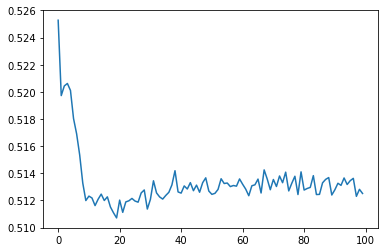

In [12]:
training_losses = train_network(100,num_steps, state_size)
plt.plot(training_losses)